In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import cm
%matplotlib inline
import os
import sys
from PIL import Image
import cv2

sys.path.append('/eagle/MDClimSim/mjp5595/ml4dvar/stormer/')
from stormer_utils_pangu import StormerWrapperPangu
from varsStormer import varsStormer

#save_dir_name = 'stormer_few_perturbs2'
save_dir_name = 'stormer_temp_perturbs'
diffs = np.load('/eagle/MDClimSim/mjp5595/data/stormer/{}/diffs.npy'.format(save_dir_name))

save_dir = '/eagle/MDClimSim/mjp5595/data/stormer/{}/'.format(save_dir_name)
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
plot_dir = os.path.join(save_dir,'plots')
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

background_file_np = '/eagle/MDClimSim/mjp5595/ml4dvar/stormer/data/background_init_stormer_norm_hr12.npy' # This is just to initialize the model background
background_f = np.load(background_file_np, 'r')
print('background_f.shape :',background_f.shape)

noise_levels = [0, 0.01, 0.1, 1, 10, 100, 1000]

/home/mjp5595/.conda/envs/climaX/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
/home/mjp5595/.conda/envs/climaX/lib/python3.8/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


background_f.shape : (1, 69, 128, 256)


### Plot Perturbation Forecasts

In [3]:
vars_stormer = varsStormer().vars_stormer
vars_units = varsStormer().var_units

forecast_scales = [12, 48, 96, 240]

forecast_orig = h5py.File(os.path.join(save_dir, 'raw_forecast_noise{}.h5'.format(noise_levels[0])),'r')

perturbations = diffs[0]
#print('perturbations.shape :',perturbations.shape)

lat = np.load('/eagle/MDClimSim/troyarcomano/1.40625deg_npz_40shards/lat.npy')
lon = np.load('/eagle/MDClimSim/troyarcomano/1.40625deg_npz_40shards/lon.npy')

for nl in noise_levels:
    print('noise_level :',nl)

    for var_idx in [0,3,11]:
        print('\tvar :',vars_stormer[var_idx])
        var_dir = os.path.join(plot_dir,'{}'.format(vars_stormer[var_idx]))
        if not os.path.exists(var_dir):
            os.makedirs(var_dir)

        gif_files = []
        forecast_perturb = h5py.File(os.path.join(save_dir, 'raw_forecast_noise{}.h5'.format(nl)),'r')

        var_lim_min = float(np.inf)
        var_lim_max = float(-np.inf)
        inc_lim_min = float(np.inf)
        inc_lim_max = float(-np.inf)
        inc_mse_max = 0
        for fs in forecast_scales:
            forecast_perturb_clean = np.where(perturbations[var_idx]!=0,forecast_orig[str(fs)][var_idx],forecast_perturb[str(fs)][var_idx])
            #var_lim_min = min(var_lim_min,np.min(forecast_orig[str(fs)][var_idx]),np.min(forecast_perturb_clean))
            #var_lim_max = max(var_lim_max,np.max(forecast_orig[str(fs)][var_idx]),np.max(forecast_perturb_clean))
            var_lim_min = min(var_lim_min,np.min(forecast_orig[str(fs)][var_idx]))
            var_lim_max = max(var_lim_max,np.max(forecast_orig[str(fs)][var_idx]))
            #inc_lim_min = min(inc_lim_min,np.min(ana_fc[str(fs)][var_idx]-bg_fc[str(fs)][var_idx]))
            increment = forecast_perturb_clean - forecast_orig[str(fs)][var_idx]
            inc_lim_max = max(inc_lim_max,np.max(np.abs(increment)))
            inc_mse_max = max(inc_mse_max,np.mean(np.square(increment)))
        #print('var_lim_min :',var_lim_min)
        #print('var_lim_max :',var_lim_max)
        #print('inc_lim_min :',inc_lim_min)
        #print('inc_lim_max :',inc_lim_max)

        mse_x = []
        mse_y = []
        fig_gif, axs_gif = plt.subplots(4,4,sharex = True, sharey = False, figsize=(20,14))
        for i,fs in enumerate(forecast_scales):
            pc_era50 = axs_gif[i,0].pcolormesh(lon, lat, forecast_orig[str(0)][var_idx], cmap='viridis', vmin=var_lim_min, vmax=var_lim_max)
            plt.colorbar(pc_era50, ax = axs_gif[i,0],label=vars_units[var_idx])
            axs_gif[i,0].set_title('Original Background & Perturbations')
            axs_gif[i,0].set_xticks(np.linspace(0,360,9))

            pc_perturb = axs_gif[i,0].pcolormesh(lon, lat, perturbations[var_idx], cmap='bwr', vmin=-1, vmax=1, alpha=np.abs(perturbations[var_idx]))

            pc_era50 = axs_gif[i,1].pcolormesh(lon, lat, forecast_orig[str(fs)][var_idx], cmap='viridis', vmin=var_lim_min, vmax=var_lim_max)
            plt.colorbar(pc_era50, ax = axs_gif[i,1],label=vars_units[var_idx])
            axs_gif[i,1].set_title('Original Forecast {}hrs'.format(fs))
            axs_gif[i,1].set_xticks(np.linspace(0,360,9))
            axs_gif[i,1].set_yticklabels([])

            forecast_perturb_clean = np.where(perturbations[var_idx]!=0,forecast_orig[str(fs)][var_idx],forecast_perturb[str(fs)][var_idx])
            increment = forecast_perturb_clean - forecast_orig[str(fs)][var_idx]

            #pc_ana0 = axs_gif[i,2].pcolormesh(lon, lat, forecast_perturb_clean, cmap='viridis', vmin=var_lim_min, vmax=var_lim_max)
            pc_ana0 = axs_gif[i,2].pcolormesh(lon, lat, forecast_perturb_clean, cmap='viridis')
            plt.colorbar(pc_ana0, ax = axs_gif[i,2],label=vars_units[var_idx])
            axs_gif[i,2].set_title('Perturbed Forecast {}hrs'.format(fs))
            axs_gif[i,2].get_yaxis().set_ticklabels([])

            pc_inc0 = axs_gif[i,3].pcolormesh(lon, lat, increment, 
                                            cmap='RdYlBu_r',
                                            norm=colors.SymLogNorm(linthresh=1,vmin=-inc_lim_max,vmax=inc_lim_max),
                                            )

            plt.colorbar(pc_inc0, ax = axs_gif[i,3], label=vars_units[var_idx])
            axs_gif[i,3].set_title('Increment (Perturb - GT_Pred) {}hrs'.format(fs))
            axs_gif[i,3].set_yticks([])

            axs_mses = axs_gif[i,3].twinx()
            axs_mses.set_ylim(0,inc_mse_max)
            axs_mses.yaxis.tick_left()
            axs_mses.yaxis.set_label_position('left')
            axs_mses.set_ylabel('Mean Squared Error ({})'.format(vars_units[var_idx]))
            mse_x.append(i*(359/(len(forecast_scales)-1)))
            mse_y.append(np.mean(np.square(increment)))
            axs_mses.plot(mse_x,mse_y,c='k')

        fig_gif.suptitle('Stormer Perturbed Forecasts ({}) - noise level {} std'.format(vars_stormer[var_idx],nl),fontsize=20)
        plt.tight_layout()

        plt.savefig(os.path.join(var_dir,'perturb_{}_{}.png'.format(vars_stormer[var_idx],nl)))
        plt.close()

perturbations.shape : (69, 128, 256)
var_lim_min : 222.97664
var_lim_max : 311.5093
inc_lim_min : inf
inc_lim_max : 0.0


/tmp/ipykernel_250298/18750556.py:75: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  plt.colorbar(pc_inc0, ax = axs_gif[i,3], label=vars_units[var_idx])
/tmp/ipykernel_250298/18750556.py:80: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  axs_mses.set_ylim(0,inc_mse_max)


var_lim_min : 95317.47
var_lim_max : 104432.29
inc_lim_min : inf
inc_lim_max : 0.0
var_lim_min : 45692.656
var_lim_max : 58263.766
inc_lim_min : inf
inc_lim_max : 0.0
var_lim_min : 222.97664
var_lim_max : 311.5093
inc_lim_min : inf
inc_lim_max : 0.08041382
var_lim_min : 95317.47
var_lim_max : 104432.29
inc_lim_min : inf
inc_lim_max : 11.53125
var_lim_min : 45692.656
var_lim_max : 58263.766
inc_lim_min : inf
inc_lim_max : 14.324219
var_lim_min : 222.97664
var_lim_max : 311.5093
inc_lim_min : inf
inc_lim_max : 0.9228821
var_lim_min : 95317.47
var_lim_max : 104432.29
inc_lim_min : inf
inc_lim_max : 113.57031
var_lim_min : 45692.656
var_lim_max : 58263.766
inc_lim_min : inf
inc_lim_max : 119.76172
var_lim_min : 222.97664
var_lim_max : 311.5093
inc_lim_min : inf
inc_lim_max : 7.232025
var_lim_min : 95317.47
var_lim_max : 104432.29
inc_lim_min : inf
inc_lim_max : 1454.3047
var_lim_min : 45692.656
var_lim_max : 58263.766
inc_lim_min : inf
inc_lim_max : 1702.8438
var_lim_min : 222.97664
var_li

### Make Perturbation Forecast Gif

In [8]:
vars_stormer = varsStormer().vars_stormer
vars_units = varsStormer().var_units

forecast_scales = np.arange(0,246,6)

forecast_orig = h5py.File(os.path.join(save_dir, 'raw_forecast_noise{}.h5'.format(noise_levels[0])),'r')

perturbations = diffs[0]
#print('perturbations.shape :',perturbations.shape)

lat = np.load('/eagle/MDClimSim/troyarcomano/1.40625deg_npz_40shards/lat.npy')
lon = np.load('/eagle/MDClimSim/troyarcomano/1.40625deg_npz_40shards/lon.npy')

for nl_idx,nl in enumerate(noise_levels):
    print('noise_level :',nl)
    for var_idx in [0,3,11]:
        print('\tvar :',vars_stormer[var_idx])
        noise_dir = os.path.join(plot_dir,'{}'.format(vars_stormer[var_idx]),'noise_{}'.format(nl))
        if not os.path.exists(noise_dir):
            os.makedirs(noise_dir)

        gif_files = []
        forecast_perturb = h5py.File(os.path.join(save_dir, 'raw_forecast_noise{}.h5'.format(nl)),'r')

        var_lim_min = float(np.inf)
        var_lim_max = float(-np.inf)
        inc_lim_min = float(np.inf)
        inc_lim_max = float(-np.inf)
        inc_mse_max = 0
        for fs in forecast_scales:
            forecast_perturb_clean = np.where(perturbations[var_idx]!=0,forecast_orig[str(fs)][var_idx],forecast_perturb[str(fs)][var_idx])
            #var_lim_min = min(var_lim_min,np.min(forecast_orig[str(fs)][var_idx]),np.min(forecast_perturb_clean))
            #var_lim_max = max(var_lim_max,np.max(forecast_orig[str(fs)][var_idx]),np.max(forecast_perturb_clean))
            var_lim_min = min(var_lim_min,np.min(forecast_orig[str(fs)][var_idx]))
            var_lim_max = max(var_lim_max,np.max(forecast_orig[str(fs)][var_idx]))
            #inc_lim_min = min(inc_lim_min,np.min(ana_fc[str(fs)][var_idx]-bg_fc[str(fs)][var_idx]))
            increment = forecast_perturb_clean - forecast_orig[str(fs)][var_idx]
            inc_lim_max = max(inc_lim_max,np.max(np.abs(increment)))
            inc_mse_max = max(inc_mse_max,np.mean(np.square(increment)))
        #print('var_lim_min :',var_lim_min)
        #print('var_lim_max :',var_lim_max)
        #print('inc_lim_min :',inc_lim_min)
        #print('inc_lim_max :',inc_lim_max)

        mse_x = []
        mse_y = []
        for i,fs in enumerate(forecast_scales[1:]):
            fig_gif, axs_gif = plt.subplots(1,4,sharex = True, sharey = False, figsize=(20,4))
            pc_era50 = axs_gif[0].pcolormesh(lon, lat, forecast_orig[str(0)][var_idx], cmap='viridis', vmin=var_lim_min, vmax=var_lim_max)
            plt.colorbar(pc_era50, ax = axs_gif[0],label=vars_units[var_idx])
            axs_gif[0].set_title('Original Background & Perturbations')
            axs_gif[0].set_xticks(np.linspace(0,360,9))

            pc_perturb = axs_gif[0].pcolormesh(lon, lat, perturbations[var_idx], cmap='bwr', vmin=-1, vmax=1, alpha=np.abs(perturbations[var_idx]))

            pc_era50 = axs_gif[1].pcolormesh(lon, lat, forecast_orig[str(fs)][var_idx], cmap='viridis', vmin=var_lim_min, vmax=var_lim_max)
            plt.colorbar(pc_era50, ax = axs_gif[1],label=vars_units[var_idx])
            axs_gif[1].set_title('Original Forecast')
            axs_gif[1].set_xticks(np.linspace(0,360,9))

            forecast_perturb_clean = np.where(perturbations[var_idx]!=0,forecast_orig[str(fs)][var_idx],forecast_perturb[str(fs)][var_idx])
            increment = forecast_perturb_clean - forecast_orig[str(fs)][var_idx]

            #pc_ana0 = axs_gif[2].pcolormesh(lon, lat, forecast_perturb_clean, cmap='viridis', vmin=var_lim_min, vmax=var_lim_max)
            pc_ana0 = axs_gif[2].pcolormesh(lon, lat, forecast_perturb_clean, cmap='viridis')
            plt.colorbar(pc_ana0, ax = axs_gif[2],label=vars_units[var_idx])
            axs_gif[2].set_title('Perturbed Forecast {}hrs'.format(fs))
            axs_gif[2].get_yaxis().set_ticklabels([])

            pc_inc0 = axs_gif[3].pcolormesh(lon, lat, increment,
                                            cmap='RdYlBu_r', vmin=-inc_lim_max, vmax=inc_lim_max,
                                            #cmap='RdYlBu_r',
                                            #norm=colors.SymLogNorm(linthresh=1,vmin=-inc_lim_max,vmax=inc_lim_max),
                                            )
            plt.colorbar(pc_inc0, ax = axs_gif[3], label=vars_units[var_idx])
            axs_gif[3].set_title('Increment (Perturb - GT_Pred) {}hrs'.format(fs))
            axs_gif[3].set_yticks([])

            axs_mses = axs_gif[3].twinx()
            axs_mses.set_ylim(0,inc_mse_max)
            axs_mses.yaxis.tick_left()
            axs_mses.yaxis.set_label_position('left')
            axs_mses.set_ylabel('Mean Squared Error ({})'.format(vars_units[var_idx]))
            mse_x.append(i*(359/(len(forecast_scales)-1)))
            mse_y.append(np.mean(np.square(increment)))
            axs_mses.plot(mse_x,mse_y,c='k')

            fig_gif.suptitle('Stormer Perturbed Forecasts ({}) - Noise Level {} std'.format(vars_stormer[var_idx],nl))
            plt.tight_layout()

            plt.savefig(os.path.join(noise_dir,'{}.png'.format(i)))
            plt.close()

            gif_files.append(os.path.join(noise_dir,'{}.png'.format(i)))

        frames_per_second = 6
        w, h = None, None
        for j,gif_f in enumerate(gif_files):
            frame = cv2.imread(gif_f)
            
            if w is None:
                h, w, _ = frame.shape
                fourcc = cv2.VideoWriter_fourcc('m','p','4','v')
                writer = cv2.VideoWriter(os.path.join(noise_dir,'perturbed_forecasts_{}_noise{}.mp4'.format(vars_stormer[var_idx],nl)),
                                         fourcc,
                                         frames_per_second,
                                         (w,h),
                                         )
            writer.write(frame)
            if j == 0 or j == (len(gif_files)-1):
                for _ in range(frames_per_second):
                    writer.write(frame)
        writer.release()

        gif_imgs = []
        for gif_f in gif_files:
            gif_imgs.append(Image.open(gif_f))

        # create extra copies of the frist and last frame
        for x in range(0, 5):
            im = gif_imgs[0]
            gif_imgs.insert(0,im)
            im = gif_imgs[-1]
            gif_imgs.append(im)

        gif_imgs[0].save(os.path.join(noise_dir,'perturbed_forecasts_{}_noise{}.gif'.format(vars_stormer[var_idx],nl)),
                    save_all=True, append_images=gif_imgs[1:], optimize=False, duration=500, loop=0)

noise_level : 0
	var : 2m_temperature


/tmp/ipykernel_250298/1959309407.py:80: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  axs_mses.set_ylim(0,inc_mse_max)


	var : mean_sea_level_pressure
	var : geopotential_500
noise_level : 0.01
	var : 2m_temperature
	var : mean_sea_level_pressure
	var : geopotential_500
noise_level : 0.1
	var : 2m_temperature
	var : mean_sea_level_pressure
	var : geopotential_500
noise_level : 1
	var : 2m_temperature
	var : mean_sea_level_pressure
	var : geopotential_500
noise_level : 10
	var : 2m_temperature
	var : mean_sea_level_pressure
	var : geopotential_500
noise_level : 100
	var : 2m_temperature
	var : mean_sea_level_pressure
	var : geopotential_500
noise_level : 1000
	var : 2m_temperature
	var : mean_sea_level_pressure
	var : geopotential_500


: 

noise_level : 0
	var : 2m_temperature


/tmp/ipykernel_80811/1162947575.py:147: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  axs_mses0.set_ylim(0,inc_mse_max)
/tmp/ipykernel_80811/1162947575.py:167: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  axs_mses1.set_ylim(0,inc_mse_max)
/tmp/ipykernel_80811/1162947575.py:185: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  axs_mses2.set_ylim(0,inc_mse_max)
/tmp/ipykernel_80811/1162947575.py:203: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  axs_mses3.set_ylim(0,inc_mse_max)


KeyboardInterrupt: 

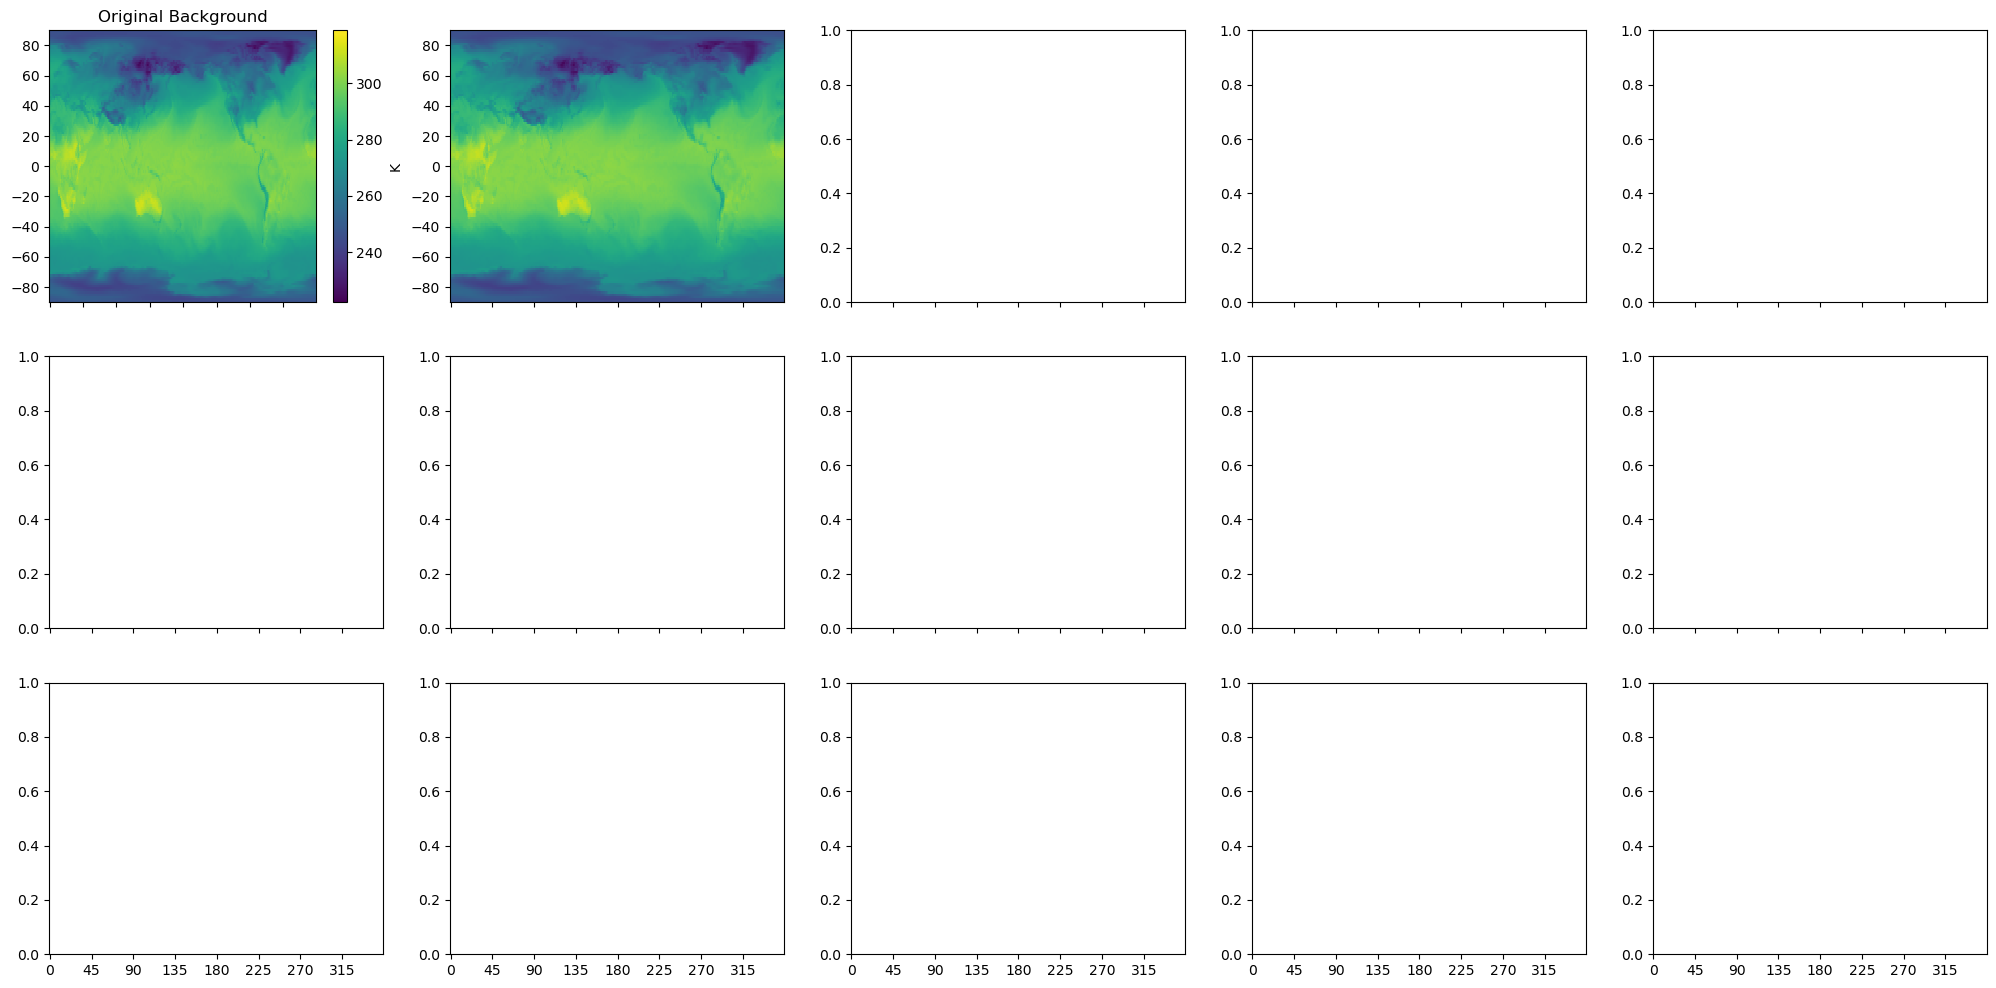

In [2]:
vars_stormer = varsStormer().vars_stormer
vars_units = varsStormer().var_units

forecast_scales = np.arange(0,246,6)
#forecast_scales = np.arange(0,240,60)

#save_dir_name = 'stormer_temp_perturbs'
#diffs = np.load('/eagle/MDClimSim/mjp5595/data/stormer/{}/diffs.npy'.format(save_dir_name))
#save_dir = '/eagle/MDClimSim/mjp5595/data/stormer/{}/'.format(save_dir_name)

save_dir_names = ['stormer_temp_perturbs','stormer_temp_perturbs2','stormer_temp_perturbs3','stormer_temp_perturbs4']
diffs_list = []
perturb_dirs = []
for sdn in save_dir_names:
    diffs_list.append(np.load('/eagle/MDClimSim/mjp5595/data/stormer/{}/diffs.npy'.format(sdn)))
    perturb_dirs.append('/eagle/MDClimSim/mjp5595/data/stormer/{}/'.format(sdn))

plot_dir = os.path.join('/eagle/MDClimSim/mjp5595/ml4dvar/plots/','perturb_combo_plots')
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

#forecast_orig = h5py.File(os.path.join(perturb_dirs[0], 'raw_forecast_noise{}.h5'.format(noise_levels[0])),'r')
forecast_orig = h5py.File(os.path.join(perturb_dirs[0], 'raw_forecast_noise0.h5'),'r')

perturbations = diffs[0]
#print('perturbations.shape :',perturbations.shape)

lat = np.load('/eagle/MDClimSim/troyarcomano/1.40625deg_npz_40shards/lat.npy')
lon = np.load('/eagle/MDClimSim/troyarcomano/1.40625deg_npz_40shards/lon.npy')

noise_levels = [0, 0.01, 0.1, 1, 10, 100, 1000]
#noise_levels = [1, 10, 100, 1000]
for nl_idx,nl in enumerate(noise_levels):
    print('noise_level :',nl)
    for var_idx in [0,3,11]:
        print('\tvar :',vars_stormer[var_idx])
        noise_dir = os.path.join(plot_dir,'{}'.format(vars_stormer[var_idx]),'noise_{}'.format(nl))
        if not os.path.exists(noise_dir):
            os.makedirs(noise_dir)

        gif_files = []
        forecast_perturbs = []
        for pd in perturb_dirs:
            forecast_perturbs.append(h5py.File(os.path.join(pd, 'raw_forecast_noise{}.h5'.format(nl)),'r'))

        var_lim_min = float(np.inf)
        var_lim_max = float(-np.inf)
        inc_lim_min = float(np.inf)
        inc_lim_max = float(-np.inf)
        inc_mse_max = 0
        for fs in forecast_scales[1:]:
            #forecast_perturb_clean = np.where(perturbations[var_idx]!=0,forecast_orig[str(fs)][var_idx],forecast_perturb[str(fs)][var_idx])
            #print('diffs_list[0][0].shape :',diffs_list[0].shape)
            #print('forecast_orig[str(fs)][var_idx] :',forecast_orig[str(fs)][var_idx].shape)
            #print('forecast_perturbs[0][str(fs)][var_idx] :',forecast_perturbs[0][str(fs)][var_idx].shape)
            #var_lim_min = min(var_lim_min,np.min(forecast_orig[str(fs)][var_idx]),np.min(forecast_perturb_clean))
            #var_lim_max = max(var_lim_max,np.max(forecast_orig[str(fs)][var_idx]),np.max(forecast_perturb_clean))
            var_lim_min = min(var_lim_min,np.min(forecast_orig[str(fs)][var_idx]))
            var_lim_max = max(var_lim_max,np.max(forecast_orig[str(fs)][var_idx]))
            #inc_lim_min = min(inc_lim_min,np.min(ana_fc[str(fs)][var_idx]-bg_fc[str(fs)][var_idx]))
            for dl_idx,dl in enumerate(diffs_list):
                forecast_perturb_clean = np.where(dl[0][var_idx]!=0,forecast_orig[str(fs)][var_idx],forecast_perturbs[dl_idx][str(fs)][var_idx])
                increment = forecast_perturb_clean - forecast_orig[str(fs)][var_idx]
                inc_lim_max = max(inc_lim_max,np.max(np.abs(increment)))
                inc_mse_max = max(inc_mse_max,np.mean(np.square(increment)))
                #print('\tinc_mse_max[{}] - fs({}) : {}'.format(dl_idx,fs,np.mean(np.square(increment))))
            #print('inc_mse_max - fs, {} : {}'.format(fs,inc_mse_max))
        #print('var_lim_min :',var_lim_min)
        #print('var_lim_max :',var_lim_max)
        #print('inc_lim_min :',inc_lim_min)
        #print('inc_lim_max :',inc_lim_max)
        #print('inc_mse_max :',inc_mse_max)

        mse_x = []
        mse_y0 = []
        mse_y1 = []
        mse_y2 = []
        mse_y3 = []
        for i,fs in enumerate(forecast_scales[1:]):
            fig_gif, axs_gif = plt.subplots(3,5,sharex = True, sharey = False, figsize=(25,12))

            pc_era50 = axs_gif[0, 0].pcolormesh(lon, lat, forecast_orig[str(0)][var_idx], cmap='viridis', vmin=var_lim_min, vmax=var_lim_max)
            plt.colorbar(pc_era50, ax = axs_gif[0, 0],label=vars_units[var_idx])
            axs_gif[0, 0].set_title('Original Background')
            axs_gif[0, 0].set_xticks(np.linspace(0,360,9))

            axs_gif[0, 1].pcolormesh(lon, lat, forecast_orig[str(0)][var_idx], cmap='viridis', vmin=var_lim_min, vmax=var_lim_max)
            axs_gif[0, 1].pcolormesh(lon, lat, diffs_list[0][0][var_idx], cmap='bwr', vmin=-1, vmax=1, alpha=np.abs(diffs_list[0][0][var_idx]))
            axs_gif[0, 2].pcolormesh(lon, lat, forecast_orig[str(0)][var_idx], cmap='viridis', vmin=var_lim_min, vmax=var_lim_max)
            axs_gif[0, 2].pcolormesh(lon, lat, diffs_list[1][0][var_idx], cmap='bwr', vmin=-1, vmax=1, alpha=np.abs(diffs_list[1][0][var_idx]))
            axs_gif[0, 3].pcolormesh(lon, lat, forecast_orig[str(0)][var_idx], cmap='viridis', vmin=var_lim_min, vmax=var_lim_max)
            axs_gif[0, 3].pcolormesh(lon, lat, diffs_list[2][0][var_idx], cmap='bwr', vmin=-1, vmax=1, alpha=np.abs(diffs_list[2][0][var_idx]))
            axs_gif[0, 4].pcolormesh(lon, lat, forecast_orig[str(0)][var_idx], cmap='viridis', vmin=var_lim_min, vmax=var_lim_max)
            axs_gif[0, 4].pcolormesh(lon, lat, diffs_list[3][0][var_idx], cmap='bwr', vmin=-1, vmax=1, alpha=np.abs(diffs_list[3][0][var_idx]))

            #pc_perturb = axs_gif[0, 0].pcolormesh(lon, lat, perturbations[var_idx], cmap='bwr', vmin=-1, vmax=1, alpha=np.abs(perturbations[var_idx]))

            pc_era50 = axs_gif[1, 0].pcolormesh(lon, lat, forecast_orig[str(fs)][var_idx], cmap='viridis', vmin=var_lim_min, vmax=var_lim_max)
            plt.colorbar(pc_era50, ax = axs_gif[1, 0],label=vars_units[var_idx])
            axs_gif[1, 0].set_title('Original Forecast')
            axs_gif[1, 0].set_xticks(np.linspace(0,360,9))

            #forecast_perturb_clean = np.where(perturbations[var_idx]!=0,forecast_orig[str(fs)][var_idx],forecast_perturb[str(fs)][var_idx])
            forecast_perturb_cleans = []
            increments = []
            for dl_idx,dl in enumerate(diffs_list):
                fpc = np.where(dl[0][var_idx]!=0,forecast_orig[str(fs)][var_idx],forecast_perturbs[dl_idx][str(fs)][var_idx])
                forecast_perturb_cleans.append(fpc)
                inc_val = fpc - forecast_orig[str(fs)][var_idx]
                increments.append(inc_val)
                #print('\tMSI[{}] - fs({}) : {}'.format(dl_idx,fs,np.mean(np.square(inc_val))))
            #for inc_idx, incr in enumerate(increments):
            #    print('mean(square(increment[{}])) : {}'.format(inc_idx,np.mean(np.square(incr))))

            #pc_ana0 = axs_gif[2].pcolormesh(lon, lat, forecast_perturb_clean, cmap='viridis', vmin=var_lim_min, vmax=var_lim_max)
            pc_ana0 = axs_gif[1, 1].pcolormesh(lon, lat, forecast_perturb_cleans[0], cmap='viridis')
            plt.colorbar(pc_ana0, ax = axs_gif[1, 1],label=vars_units[var_idx])
            axs_gif[1, 1].set_title('Perturbed Forecast {}hrs'.format(fs))
            axs_gif[1, 1].get_yaxis().set_ticklabels([])

            pc_ana1 = axs_gif[1, 2].pcolormesh(lon, lat, forecast_perturb_cleans[1], cmap='viridis')
            plt.colorbar(pc_ana1, ax = axs_gif[1, 2],label=vars_units[var_idx])
            axs_gif[1, 2].set_title('Perturbed Forecast {}hrs'.format(fs))
            axs_gif[1, 2].get_yaxis().set_ticklabels([])

            pc_ana2 = axs_gif[1, 3].pcolormesh(lon, lat, forecast_perturb_cleans[2], cmap='viridis')
            plt.colorbar(pc_ana2, ax = axs_gif[1, 3],label=vars_units[var_idx])
            axs_gif[1, 3].set_title('Perturbed Forecast {}hrs'.format(fs))
            axs_gif[1, 3].get_yaxis().set_ticklabels([])

            pc_ana3 = axs_gif[1, 4].pcolormesh(lon, lat, forecast_perturb_cleans[3], cmap='viridis')
            plt.colorbar(pc_ana3, ax = axs_gif[1, 4],label=vars_units[var_idx])
            axs_gif[1, 4].set_title('Perturbed Forecast {}hrs'.format(fs))
            axs_gif[1, 4].get_yaxis().set_ticklabels([])

            fig_gif.delaxes(axs_gif[2,0])

            #########################################################################################################
            pc_inc0 = axs_gif[2, 1].pcolormesh(lon, lat, increments[0],
                                     cmap='RdYlBu_r', vmin=-inc_lim_max, vmax=inc_lim_max,
                                     #cmap='RdYlBu_r',
                                     #norm=colors.SymLogNorm(linthresh=1,vmin=-inc_lim_max,vmax=inc_lim_max),
                                     )
            plt.colorbar(pc_inc0, ax = axs_gif[2, 1], label=vars_units[var_idx])
            axs_gif[2, 1].set_title('Increment (Perturb - GT_Pred) {}hrs'.format(fs))
            axs_gif[2, 1].set_yticks([])

            axs_mses0 = axs_gif[2, 1].twinx()
            axs_mses0.set_ylim(0,inc_mse_max)
            axs_mses0.yaxis.tick_left()
            axs_mses0.yaxis.set_label_position('left')
            axs_mses0.set_ylabel('Mean Squared Error ({})'.format(vars_units[var_idx]))
            #mse_x.append((i+1)*(359/(len(forecast_scales)-1)))
            mse_x.append((i+1)*(359/(len(forecast_scales)-1)))
            mse_y0.append(np.mean(np.square(increments[0])))
            axs_mses0.plot(mse_x,mse_y0,c='k')
            #########################################################################################################
            #########################################################################################################
            pc_inc1 = axs_gif[2, 2].pcolormesh(lon, lat, increments[1],
                                     cmap='RdYlBu_r', vmin=-inc_lim_max, vmax=inc_lim_max,
                                     #cmap='RdYlBu_r',
                                     #norm=colors.SymLogNorm(linthresh=1,vmin=-inc_lim_max,vmax=inc_lim_max),
                                     )
            plt.colorbar(pc_inc1, ax = axs_gif[2, 2], label=vars_units[var_idx])
            axs_gif[2, 2].set_title('Increment (Perturb - GT_Pred) {}hrs'.format(fs))
            axs_gif[2, 2].set_yticks([])

            axs_mses1 = axs_gif[2, 2].twinx()
            axs_mses1.set_ylim(0,inc_mse_max)
            axs_mses1.yaxis.tick_left()
            axs_mses1.yaxis.set_label_position('left')
            axs_mses1.set_ylabel('Mean Squared Error ({})'.format(vars_units[var_idx]))
            mse_y1.append(np.mean(np.square(increments[1])))
            axs_mses1.plot(mse_x,mse_y1,c='k')
            #########################################################################################################
            #########################################################################################################
            pc_inc2 = axs_gif[2, 3].pcolormesh(lon, lat, increments[2],
                                     cmap='RdYlBu_r', vmin=-inc_lim_max, vmax=inc_lim_max,
                                     #cmap='RdYlBu_r',
                                     #norm=colors.SymLogNorm(linthresh=1,vmin=-inc_lim_max,vmax=inc_lim_max),
                                     )
            plt.colorbar(pc_inc2, ax = axs_gif[2, 3], label=vars_units[var_idx])
            axs_gif[2, 3].set_title('Increment (Perturb - GT_Pred) {}hrs'.format(fs))
            axs_gif[2, 3].set_yticks([])

            axs_mses2 = axs_gif[2, 3].twinx()
            axs_mses2.set_ylim(0,inc_mse_max)
            axs_mses2.yaxis.tick_left()
            axs_mses2.yaxis.set_label_position('left')
            axs_mses2.set_ylabel('Mean Squared Error ({})'.format(vars_units[var_idx]))
            mse_y2.append(np.mean(np.square(increments[2])))
            axs_mses2.plot(mse_x,mse_y2,c='k')
            #########################################################################################################
            #########################################################################################################
            pc_inc3 = axs_gif[2, 4].pcolormesh(lon, lat, increments[3],
                                     cmap='RdYlBu_r', vmin=-inc_lim_max, vmax=inc_lim_max,
                                     #cmap='RdYlBu_r',
                                     #norm=colors.SymLogNorm(linthresh=1,vmin=-inc_lim_max,vmax=inc_lim_max),
                                     )
            plt.colorbar(pc_inc3, ax = axs_gif[2, 4], label=vars_units[var_idx])
            axs_gif[2, 4].set_title('Increment (Perturb - GT_Pred) {}hrs'.format(fs))
            axs_gif[2, 4].set_yticks([])

            axs_mses3 = axs_gif[2, 4].twinx()
            axs_mses3.set_ylim(0,inc_mse_max)
            axs_mses3.yaxis.tick_left()
            axs_mses3.yaxis.set_label_position('left')
            axs_mses3.set_ylabel('Mean Squared Error ({})'.format(vars_units[var_idx]))
            mse_y3.append(np.mean(np.square(increments[3])))
            axs_mses3.plot(mse_x,mse_y3,c='k')
            #########################################################################################################

            fig_gif.suptitle('Stormer Perturbed Forecasts ({}) - Noise Level {} std'.format(vars_stormer[var_idx],nl))
            plt.tight_layout()

            plt.savefig(os.path.join(noise_dir,'{}.png'.format(i)))
            plt.close()

            gif_files.append(os.path.join(noise_dir,'{}.png'.format(i)))
        
        #print('mse_x :',mse_x)
        #print('mse_y0 :',mse_y0)
        #print('mse_y1 :',mse_y1)
        #print('mse_y2 :',mse_y2)
        #print('mse_y3 :',mse_y3)

        frames_per_second = 6
        w, h = None, None
        for j,gif_f in enumerate(gif_files):
            frame = cv2.imread(gif_f)
            
            if w is None:
                h, w, _ = frame.shape
                fourcc = cv2.VideoWriter_fourcc('m','p','4','v')
                writer = cv2.VideoWriter(os.path.join(noise_dir,'perturbed_forecasts_{}_noise{}.mp4'.format(vars_stormer[var_idx],nl)),
                                         fourcc,
                                         frames_per_second,
                                         (w,h),
                                         )
            writer.write(frame)
            if j == 0 or j == (len(gif_files)-1):
                for _ in range(frames_per_second):
                    writer.write(frame)
        writer.release()

        gif_imgs = []
        for gif_f in gif_files:
            gif_imgs.append(Image.open(gif_f))

        # create extra copies of the frist and last frame
        for x in range(0, 5):
            im = gif_imgs[0]
            gif_imgs.insert(0,im)
            im = gif_imgs[-1]
            gif_imgs.append(im)

        gif_imgs[0].save(os.path.join(noise_dir,'perturbed_forecasts_{}_noise{}.gif'.format(vars_stormer[var_idx],nl)),
                    save_all=True, append_images=gif_imgs[1:], optimize=False, duration=500, loop=0)